# Similarity Classification

In [1]:
import os
import glob
import csv
import pickle
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import functional as F

#### Parameters

In [2]:
path = os.path.join(os.environ['DATASETS'], 'logos')

exemplars_name = os.path.join(path, 'exemplars.zip')
logos_name = os.path.join(path, 'logos', 'all_crops.zip')

exemplars_128_name = os.path.join(path, 'exemplars_128x128.zip')
logos_128_name = os.path.join(path, 'logos', 'all_crops_128x128.zip')

exemplars_siam_name = os.path.join(path, 'exemplars_siamese.zip')
logos_siam_name = os.path.join(path, 'logos', 'all_crops_siamese.zip')

#### Load data

In [3]:
exemplars_df = pd.read_pickle(exemplars_name)
logos_df = pd.read_pickle(logos_name)
logos_df.head()

exemplars_128_df = pd.read_pickle(exemplars_128_name)
logos_128_df = pd.read_pickle(logos_128_name)

exemplars_siam_df = pd.read_pickle(exemplars_siam_name)
logos_siam_df = pd.read_pickle(logos_siam_name)

#### Filter data

In [4]:
logos_brands = Counter(logos_df['brand'])
logos_list = [b for b, c in logos_brands.items() if c >= 50]
brands_mask = logos_df['brand'].isin(logos_list)
too_many = logos_df['brand'] == 'heineken'

logos_small_df = logos_df[brands_mask & ~too_many]
logos_128_small_df = logos_128_df[brands_mask & ~too_many]
logos_siam_small_df = logos_siam_df[brands_mask & ~too_many]

### Analyze latent space

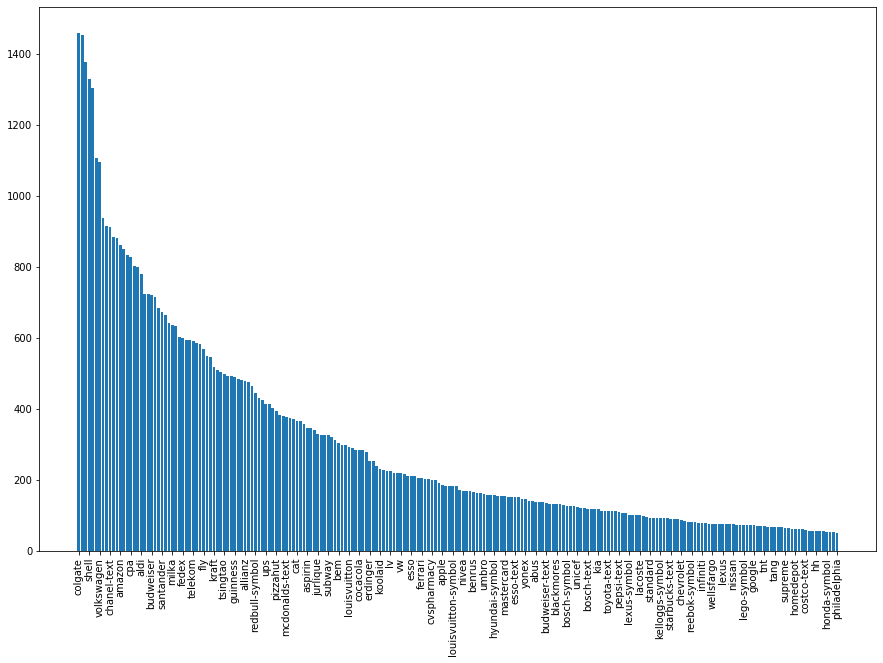

In [5]:
logos_small = Counter(logos_small_df['brand'])

x, y = zip(*logos_small.most_common())
ticks = [v for i, v in enumerate(x) if i % 3 == 0]
labels = [v for i, v in enumerate(logos_small.keys()) if i % 3 == 0]

plt.figure(figsize=(15, 10))
plt.bar(x, y)
plt.xticks(ticks, labels, rotation='vertical');

In [6]:
def get_distances(exemplars, logos, reference, metric, p=None):
    
    detections = set(logos['brand'])
    brands_list = []
    mean_list = []
    min_list = []
    max_list = []
    std_list = []
    var_list = []
    
    for idx, exemplar_brand in enumerate(tqdm(exemplars['brand'])):
        if exemplar_brand in detections:
                        
            # Fit classifier:
            exemplar_vec = exemplars['img_vec'].iloc[idx]
            neigh = KNeighborsClassifier(n_neighbors=1, metric=metric, p=p)
            neigh.fit([exemplar_vec], [1])

            # Filter brands:
            if reference.upper() == 'TP':
                brand_mask = logos['brand'] == exemplar_brand
            elif reference.upper() == 'FP':
                brand_mask = logos['brand'] != exemplar_brand
            brand_detections = list(logos['img_vec'][brand_mask])
            
            # Compute distances:
            dists, classes = neigh.kneighbors(brand_detections)

            # Store results:
            brands_list.append(exemplar_brand)
            mean_list.append(np.mean(dists))
            min_list.append(np.min(dists))
            max_list.append(np.max(dists))
            std_list.append(np.std(dists))
            var_list.append(np.var(dists))

    dists_mat = pd.DataFrame({
        'brand': brands_list,
        'mean': mean_list,
        'min': min_list,
        'max': max_list,
        'std': std_list,
        'var': var_list
        })

    return dists_mat

In [7]:
def plot_distances(mat_1, mat_2, mat_3, mat_4, mat_5, mat_6):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    labels = ['Exem - TPs', 'Exem - FPs']

    data = np.array((mat_1['mean'], mat_4['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[0].boxplot(norm, widths=0.75, labels=labels);
    axs[0].set_title('Minkowski: 1');

    data = np.array((mat_2['mean'], mat_5['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[1].boxplot(norm, widths=0.75, labels=labels);
    axs[1].set_title('Minkowski: 2');

    data = np.array((mat_3['mean'], mat_6['mean'])).T
    norm = normalize(data, axis=0, norm='l2')
    axs[2].boxplot(norm, widths=0.75, labels=labels);
    axs[2].set_title('Cosine');

## Crops of varying size

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [8]:
dists_mat_1 = get_distances(exemplars_df, logos_small_df, 'TP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:01<00:00, 296.81it/s]


##### Minkowski: 2

In [9]:
dists_mat_2 = get_distances(exemplars_df, logos_small_df, 'TP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:03<00:00, 112.82it/s]


#### Cosine

In [10]:
dists_mat_3 = get_distances(exemplars_df, logos_small_df, 'TP', metric='cosine')

100%|██████████| 352/352 [00:03<00:00, 97.39it/s] 


### Average distance: Exemplar to FPs

##### Minkowski: 1

In [11]:
dists_mat_4 = get_distances(exemplars_df, logos_small_df, 'FP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:39<00:00,  8.91it/s]


##### Minkowski: 2

In [12]:
dists_mat_5 = get_distances(exemplars_df, logos_small_df, 'FP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:54<00:00,  6.43it/s]


##### Cosine

In [13]:
dists_mat_6 = get_distances(exemplars_df, logos_small_df, 'FP', metric='cosine')

100%|██████████| 352/352 [01:29<00:00,  3.95it/s]


### Results

In [14]:
dists_mat_1.describe()

,mean,min,max,std,var
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,14.098858,7.585060,17.767407,2.010752,4.397424
std,1.418470,2.516058,0.804315,0.596560,2.473655
min,10.367033,2.611554,14.796590,0.688747,0.474372
25%,13.200129,5.662993,17.289553,1.585667,2.514339
50%,14.194569,7.378347,17.852322,1.923502,3.699860
75%,15.214635,9.288979,18.315677,2.427833,5.894372
max,17.101950,14.571014,20.051583,3.555224,12.639616


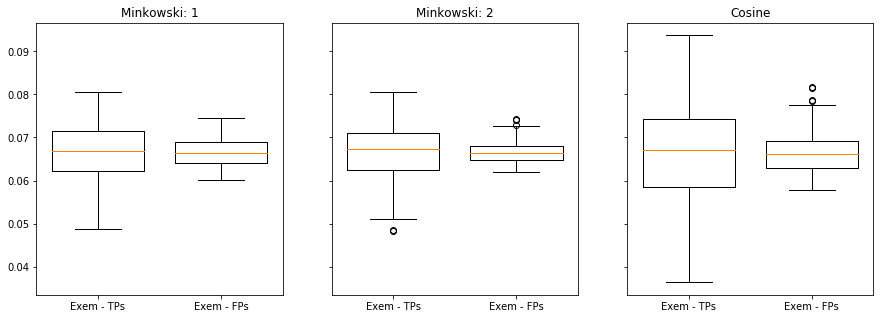

In [15]:
plot_distances(dists_mat_1, dists_mat_2, dists_mat_3,
               dists_mat_4, dists_mat_5, dists_mat_6)

## Crops of size 128x128

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [16]:
dists_mat_7 = get_distances(exemplars_128_df, logos_128_small_df, 'TP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:01<00:00, 290.68it/s]


##### Minkowski: 2

In [17]:
dists_mat_8 = get_distances(exemplars_128_df, logos_128_small_df, 'TP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:03<00:00, 111.01it/s]


#### Cosine

In [18]:
dists_mat_9 = get_distances(exemplars_128_df, logos_128_small_df, 'TP', metric='cosine')

100%|██████████| 352/352 [00:03<00:00, 98.68it/s] 


### Average distance: Exemplar to FPs

##### Minkowski: 1

In [19]:
dists_mat_10 = get_distances(exemplars_128_df, logos_128_small_df, 'FP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:39<00:00,  9.01it/s]


##### Minkowski: 2

In [20]:
dists_mat_11 = get_distances(exemplars_128_df, logos_128_small_df, 'FP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:55<00:00,  6.37it/s]


##### Cosine

In [21]:
dists_mat_12 = get_distances(exemplars_128_df, logos_128_small_df, 'FP', metric='cosine')

100%|██████████| 352/352 [01:29<00:00,  3.92it/s]


### Results

In [22]:
dists_mat_7.describe()

,mean,min,max,std,var
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,12.655043,6.061726,16.370236,2.050897,4.557471
std,1.441760,2.369848,0.686062,0.594020,2.616955
min,8.930069,0.958470,13.832942,0.972823,0.946385
25%,11.611349,4.099980,15.994365,1.571423,2.469372
50%,12.772298,5.917480,16.372285,1.963949,3.857098
75%,13.722346,7.993221,16.791987,2.483985,6.170183
max,15.399660,11.550732,18.003920,3.733224,13.936963


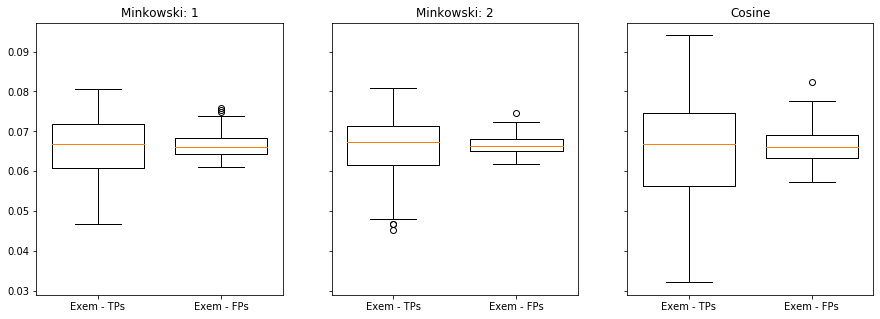

In [23]:
plot_distances(dists_mat_7, dists_mat_8, dists_mat_9,
               dists_mat_10, dists_mat_11, dists_mat_12)

## Siamese Embedding

### Average distance: Exemplar to TPs

##### Minkowski: 1

In [24]:
dists_mat_13 = get_distances(exemplars_siam_df, logos_siam_small_df, 'TP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:01<00:00, 300.82it/s]


##### Minkowski: 2

In [25]:
dists_mat_14 = get_distances(exemplars_siam_df, logos_siam_small_df, 'TP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:03<00:00, 113.35it/s]


#### Cosine

In [26]:
dists_mat_15 = get_distances(exemplars_siam_df, logos_siam_small_df, 'TP', metric='cosine')

100%|██████████| 352/352 [00:03<00:00, 103.98it/s]


### Average distance: Exemplar to FPs

##### Minkowski: 1

In [27]:
dists_mat_16 = get_distances(exemplars_siam_df, logos_siam_small_df, 'FP', metric='minkowski', p=1)

100%|██████████| 352/352 [00:29<00:00, 12.05it/s]


##### Minkowski: 2

In [28]:
dists_mat_17 = get_distances(exemplars_siam_df, logos_siam_small_df, 'FP', metric='minkowski', p=2)

100%|██████████| 352/352 [00:45<00:00,  7.72it/s]


##### Cosine

In [29]:
dists_mat_18 = get_distances(exemplars_siam_df, logos_siam_small_df, 'FP', metric='cosine')

100%|██████████| 352/352 [01:09<00:00,  5.09it/s]


### Results

In [30]:
dists_mat_13.describe()

,mean,min,max,std,var
count,225.000000,225.000000,225.000000,225.000000,225.000000
mean,1.444734,0.265246,3.285712,0.728561,0.598723
std,0.607067,0.215564,0.512965,0.261200,0.435493
min,0.496929,0.029486,1.834708,0.278147,0.077366
25%,0.966497,0.133158,2.929465,0.521787,0.272262
50%,1.332165,0.194007,3.281439,0.695320,0.483470
75%,1.785776,0.316962,3.608402,0.889369,0.790977
max,3.276855,1.461451,4.427925,1.558754,2.429715


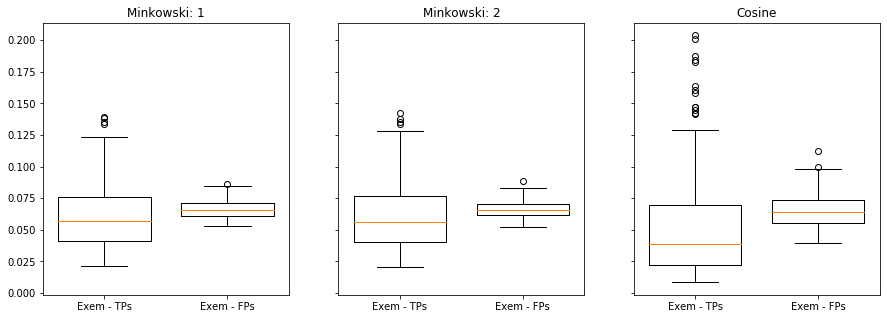

In [31]:
plot_distances(dists_mat_13, dists_mat_14, dists_mat_15,
               dists_mat_16, dists_mat_17, dists_mat_18)